In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [2]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from evallm.experiments.transducer_summary import (
    for_model_and_prompt as for_model_t,
    compute_model_results as compute_model_results_t,
    compute_deterministic_baseline_outcomes as dbo_t,
)

from evallm.experiments.sequence_completion_summary import (
    for_model as for_model_sc,
    current_setting as current_setting_s,
    results_for_baseline as rfb_s,
)
from evallm.experiments.sequence_completion.sequence_completion_prompt import (
    WithTemperatureSequenceCompletionPrompt,
)
from evallm.prompting.transducer_prompt import WithTemperatureTransducerPrompter

from evallm.experiments.transducer_plotting import (
    setup_plot,
)

from evallm.experiments.results_by_difficulty.plotting import THEME_COLORS

In [3]:
count = 1000

In [91]:
def produce_transducer_results(max_gram, include_infinity_gram, **kwargs):
    r = for_model_t(
        "mistral-nemo-minitron-8B",
        count,
        "Basic",
        **kwargs,
    )

    baselines = {
        mod: {prompt: np.mean(v) for prompt, v in by_prompt.items()}
        for mod, by_prompt in dbo_t(
            **kwargs,
            include_brute_force=False,
            include_null=False,
            min_gram=4,
            max_gram=max_gram,
            include_infinity_gram=include_infinity_gram,
        ).items()
    }

    models = {
        mod: {prompt: np.mean(res) for prompt, res in prompts_res.items()}
        for mod, prompts_res in compute_model_results_t(
            r, accuracy_summary=True
        ).items()
    }

    overall = {**baselines, **models}
    return {k: v["Basic"] for k, v in overall.items()}


def plot_results(ax, results, title, xlabel, xlog):
    setup_plot()
    for i, k in enumerate(results):
        ax.plot(
            results.index,
            100 * results[k],
            label=k,
            color="black" if "Gram" not in k else THEME_COLORS[:-1][i],
        )
    ax.legend()
    if xlog:
        ax.set_xscale("log")
    ax.set_xticks(results.index, results.index)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r"Accuracy [\%]")
    ax.set_title(title)
    ax.grid()
    ax.set_ylim(ax.get_ylim()[0], 100)


def plot_both(t, sc, xlabel, xlog):
    size = 4
    _, axs = plt.subplots(1, 2, figsize=(size * 2, size), dpi=200)
    plot_results(axs[0], t, "Transducer", xlabel, xlog)
    plot_results(axs[1], sc, "Sequence Completion", xlabel, xlog)

In [92]:
nss_vals = [30, 60, 150, 300, 600]

transducer_results = pd.DataFrame(
    [
        produce_transducer_results(
            max_gram=7, include_infinity_gram=True, num_sequence_symbols=nss
        )
        for nss in nss_vals
    ],
    index=nss_vals,
)

In [68]:
def produce_sc_results(**kwargs):
    setting = {**current_setting_s, **kwargs}
    r = for_model_sc(
        "mistral-nemo-minitron-8B",
        count,
        "Basic",
        na_mode="ignore",
        setting=setting,
    )
    r.update(rfb_s(setting, include_non_ngram=False, min_ngram=4))
    results = defaultdict(dict)
    for mod, prompt in r:
        assert prompt == "Basic"
        results[mod] = np.mean(r[mod, prompt])
    return results

In [69]:
sc_results = pd.DataFrame(
    [produce_sc_results(num_sequences=nss) for nss in nss_vals],
    index=nss_vals,
)

In [70]:
sc_results

,mistral-nemo-minitron-8B,4-\textsc{Gram}$_S$,5-\textsc{Gram}$_S$,6-\textsc{Gram}$_S$
30,0.787033,0.896267,0.911667,0.917100
60,0.821167,0.894000,0.912233,0.924500
150,0.851667,0.892133,0.913300,0.931667
300,0.867433,0.893633,0.912200,0.931133
600,0.886800,0.896000,0.911767,0.922633


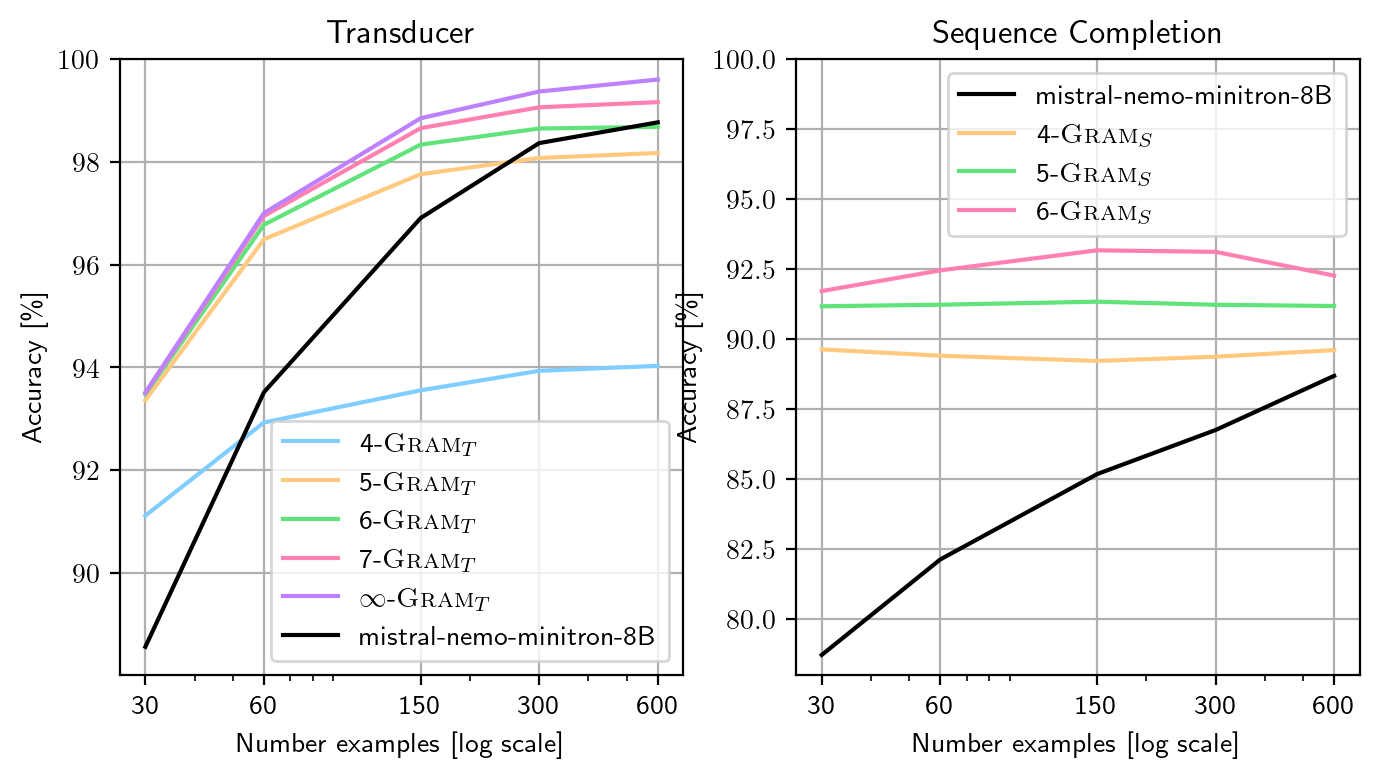

In [93]:
plot_both(transducer_results, sc_results, "Number examples [log scale]", True)
plt.savefig("../output/more-examples-per-problem.png")

In [80]:
num_states_to_try = [3, 4, 5, 6, 7, 8]

In [85]:
transducer_results_varying_states = pd.DataFrame(
    [
        produce_transducer_results(
            max_gram=6,
            include_infinity_gram=False,
            num_states=num_states,
            num_sequence_symbols=30,
        )
        for num_states in num_states_to_try
    ],
    index=num_states_to_try,
)

In [86]:
transducer_results_varying_states

,4-\textsc{Gram}$_T$,5-\textsc{Gram}$_T$,6-\textsc{Gram}$_T$,mistral-nemo-minitron-8B
3,0.911133,0.933600,0.934767,0.8856
4,0.852117,0.877017,0.880917,0.8343
5,0.829867,0.851733,0.856433,0.8115
6,0.793333,0.814300,0.818633,0.7769
7,0.771700,0.791967,0.796433,0.7590
8,0.749467,0.767900,0.772700,0.7353


In [87]:
sc_results_varying_states = pd.DataFrame(
    [
        produce_sc_results(
            num_sequences=30,
            dfa_spec={**current_setting_s["dfa_spec"], "n_states": num_states},
        )
        for num_states in num_states_to_try
    ],
    index=num_states_to_try,
)

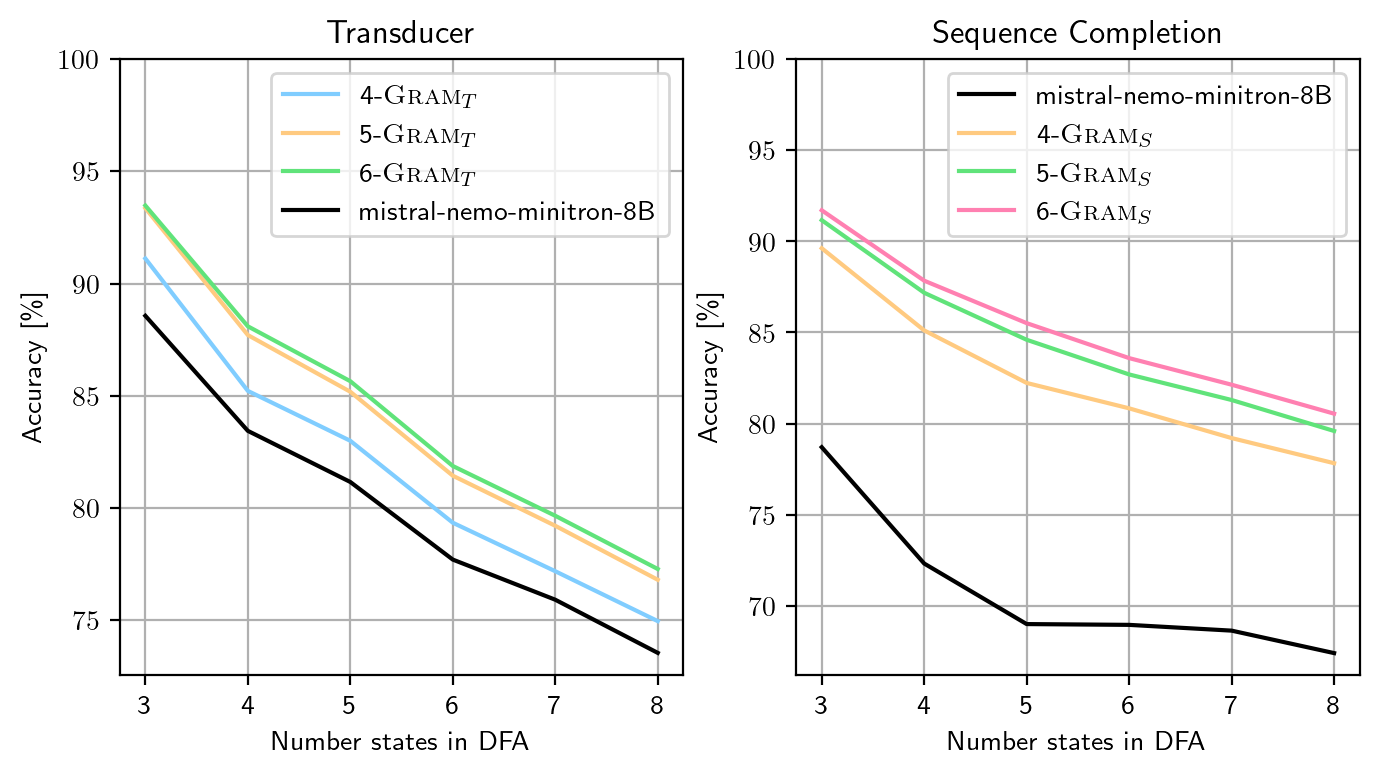

In [96]:
plot_both(
    transducer_results_varying_states,
    sc_results_varying_states,
    "Number states in DFA",
    False,
)
plt.savefig("../output/more-states-per-problem.png")